# Gold-Silver Spread Trading

El siguiente código tiene como objetivo evaluar la estrategia del spread entre el oro y la plata. Esta estrategia consiste en medir el ratio entre el oro y la plata. Como premisa principal, el promedio de los futuros del oro/plata ha sido de 80. La manera de captar la divergencia va a ser en una ventana móvil del ratio estandarizado en valores z. El código va a estar divido en 6 partes.

**1. Extracción de datos y definición de parámetros**

 En esta parte nos centraremos en obtener los datos de los activos que nos interesan y definir los parámetros que queremos. 

**2. Análisis exploratorio de los datos**

 Esta parte será para visualizar los datos. Esto con el objetivo de encontrar patrones, o hallazgos interesantes que puedan contribuír en la investigación y estrategia. 
 
**3. Optimización de la estrategia**

En esta parte encontraremos los mejores umbrales para realizar trades. 

**4. Análisis de la optimización**

En esta parte nos centraremos en analizar y evaluar el performance de la estrategia y su respectiva optimización. 

**5. Aplicar un WFO y validar su significancia estadística**

En esta parte vamos a probar la optimización en diferentes ventanas de entrenamiento y prueba. 

**6. Analizar y verificar resultados del WFO**

Validar la significancia estadística y analizar resultados de los umbrales. 

## Importación de librerías

In [1]:
import pandas as pd
import vectorbt as vbt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

!pip install vectorbt

## Extración de datos y definición de parámetros

In [2]:
# Define parameters
window = 21  # Moving window size for calculations
threshold = 1.5  # Threshold value for decision-making

# Define ticker symbols
silver = "SI=F"        # Ticker for silver futures
gold = "GC=F"          # Ticker for gold futures
silver_etf = "SLV"     # Ticker for silver ETF
gold_etf = "GLD"       # Ticker for gold ETF

# Set the date range for data retrieval
start = pd.Timestamp("2010-01-01")  # Start date
end = pd.Timestamp("2024-10-01")    # End date

# Download historical price data for silver and gold futures
prices = vbt.YFData.download(
    [silver, gold],
    start=start,
    end=end, 
    missing_index="drop"  # Drop any missing dates
)

# Extract closing prices for silver futures
silver_prices = prices.get("Close")[silver]

# Extract closing prices for gold futures
gold_prices = prices.get("Close")[gold]

# Extract closing prices for all downloaded instruments
future_prices = prices.get("Close")


In [3]:
# Download historical price data for silver and gold ETFs
etf_prices = vbt.YFData.download(
    [silver_etf, gold_etf],  # List of ETF tickers to download
    start=start,              # Start date for the data
    end=end,                  # End date for the data
    missing_index="drop"      # Drop any dates with missing data
)

# Extract closing prices from the downloaded ETF data
etf_prices_df = etf_prices.get("Close")  # DataFrame containing closing prices of the ETFs


In [4]:
future_prices.shape

(3708, 2)

In [5]:
# Create a common index by taking the union of dates from both assets
common_index = future_prices.index.union(etf_prices_df.index).sort_values()

# Reindex both DataFrames using the common index
future_prices_aligned = future_prices.reindex(common_index)
etf_prices_aligned = etf_prices_df.reindex(common_index)

# Forward-fill to handle any missing data after re


In [6]:
# Extract aligned closing prices for silver futures
sl = future_prices_aligned[silver]  # Silver futures prices

# Extract aligned closing prices for gold futures
gl = future_prices_aligned[gold]    # Gold futures prices

# Extract aligned closing prices for the Gold ETF
gld = etf_prices_aligned[gold_etf]  # Gold ETF (GLD) prices

# Extract aligned closing prices for the Silver ETF
slv = etf_prices_aligned[silver_etf]  # Silver ETF (SLV) prices

# Calculate the ratio of gold futures price to silver futures price
ratio = gl / sl  # Ratio of Gold to Silver futures


In [7]:
# Ensure all series have the same length and indices
if len(sl) != len(gl) or len(gld) != len(slv) or len(sl) != len(gld):
    print("series have different lengths")  # Check if any series have different lengths
elif not (sl.index.equals(gl.index) and gld.index.equals(slv.index) and sl.index.equals(gld.index)):
    print("series have different indices")  # Check if any series have different indices
else:
    print("all series have the same length and index")  # All checks passed

all series have the same length and index


# Análisis exploratorio de los datos

In [8]:
sns.set_theme()

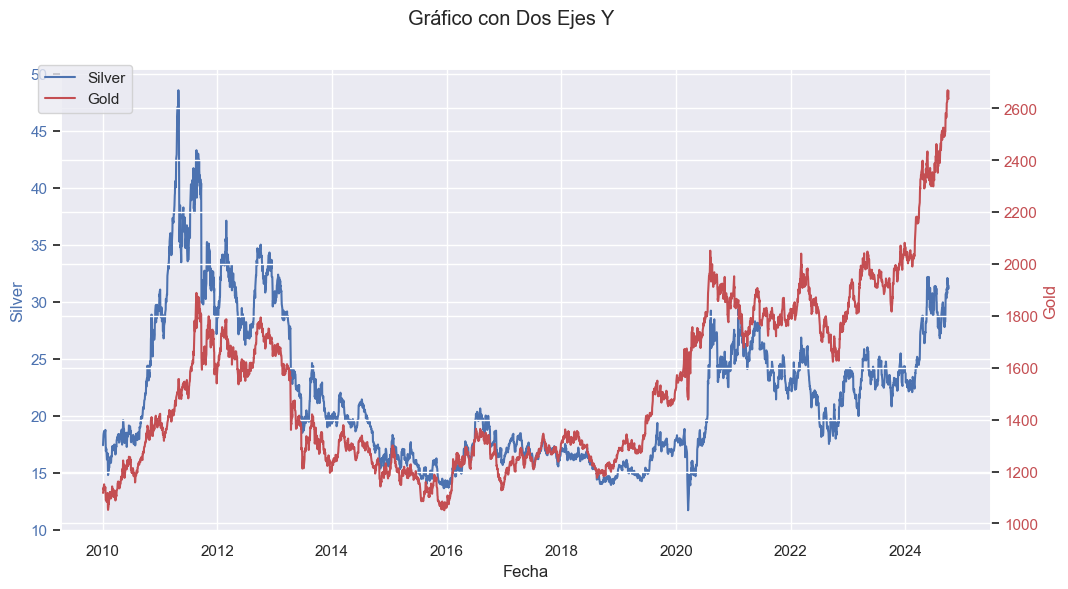

In [12]:
# Create the figure and the main axis
fig, ax1 = plt.subplots(figsize=(12, 6))  # Initialize a figure with a specified size

# Plot the first variable (Silver) on the primary y-axis
ax1.plot(sl.index, sl, color='b', label='Silver')  # Plot Silver prices in blue
ax1.set_xlabel('Date')                             # Set the x-axis label to 'Date'
ax1.set_ylabel('Silver', color='b')                # Set the y-axis label to 'Silver' with blue color
ax1.tick_params(axis='y', labelcolor='b')          # Set y-axis tick parameters to blue

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()                                   # Initialize a secondary y-axis
ax2.plot(gl.index, gl, color='r', label='Gold')     # Plot Gold prices in red
ax2.set_ylabel('Gold', color='r')                   # Set the secondary y-axis label to 'Gold' with red color
ax2.tick_params(axis='y', labelcolor='r')          # Set secondary y-axis tick parameters to red

# Add title and legend
fig.suptitle('Dual Y-Axis Plot')                     # Set the main title of the figure
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))  # Add a legend to the upper left corner


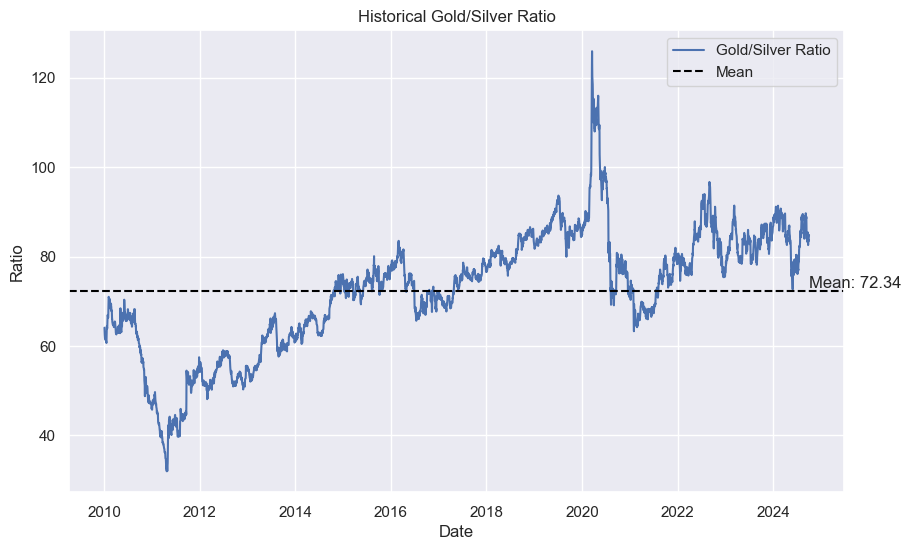

In [60]:
# Plot the Gold/Silver ratio
plt.plot(ratio.index, ratio, label="Gold/Silver Ratio")  # Plot the ratio over time with a label

# Add a horizontal line representing the mean of the ratio
plt.axhline(ratio.mean(), color="black", linestyle="--", label="Mean")  # Dashed black line for mean value

# Annotate the mean value on the plot
plt.text(
    ratio.index[-1],                           # Position the text at the last date
    ratio.mean(),                              # Y-coordinate is the mean value
    f"Mean: {ratio.mean():.2f}",               # Text to display
    verticalalignment="bottom"                 # Align text vertically to the bottom
)

# Add a legend to the plot
plt.legend()  # Display the legend based on the labels provided in plot and axhline

# Set the title of the plot
plt.title("Historical Gold/Silver Ratio")  # Title of the plot

# Label the x-axis
plt.xlabel("Date")  # Label for the x-axis

# Label the y-axis
plt.ylabel("Ratio")  # Label for the y-axis

# Display the plot
plt.show()  # Render and display the plot



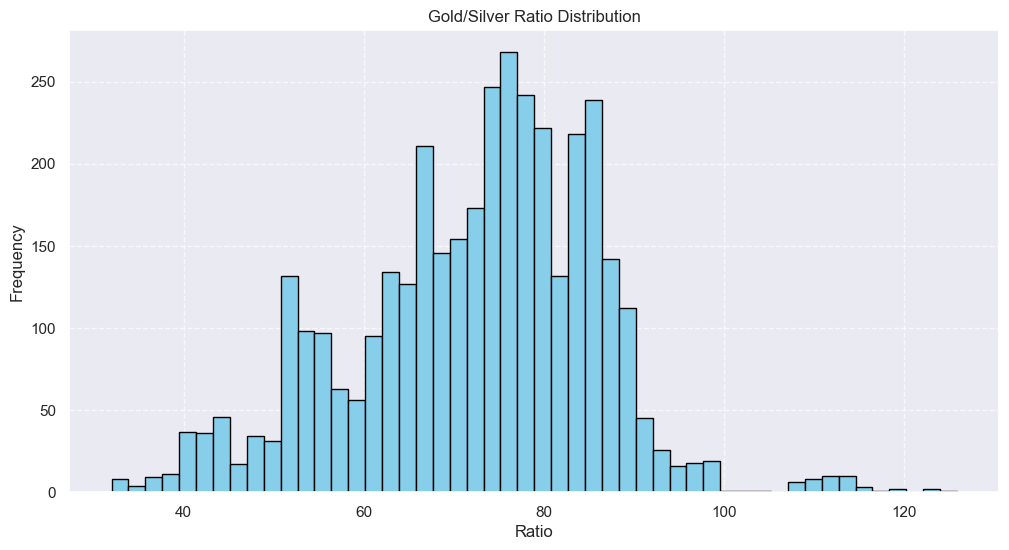

In [59]:
# Create a new figure with a specified size
plt.figure(figsize=(12, 6))  # Initialize a figure with a width of 12 inches and a height of 6 inches

# Plot a histogram of the Gold/Silver ratio
plt.hist(ratio, bins=50, color='skyblue', edgecolor='black')  # Plot histogram with 50 bins, sky blue bars, and black edges

# Set the title of the histogram
plt.title("Gold/Silver Ratio Distribution")  # Title of the histogram

# Label the x-axis
plt.xlabel("Ratio")  # Label for the x-axis

# Label the y-axis
plt.ylabel("Frequency")  # Label for the y-axis

# Optionally, add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)  # Add dashed grid lines with 70% opacity

# Display the histogram
plt.show()  # Render and display the histogram


In [15]:
# Calculate the logarithmic returns for Gold futures
log_returns_gl = np.log(gl / gl.shift(1))  # Compute log returns by taking the natural log of the ratio of current to previous gold prices

# Calculate the logarithmic returns for Silver futures
log_returns_sl = np.log(sl / sl.shift(1))  # Compute log returns by taking the natural log of the ratio of current to previous silver prices

In [16]:
# Calculate the correlation between Gold and Silver log returns
correlation_total = log_returns_gl.corr(log_returns_sl)  # Compute Pearson correlation coefficient between gold and silver log returns

# Print the correlation value
print(f"Correlation between Gold and Silver Log Returns: {correlation_total:.4f}")  # Display the correlation with four decimal places

0.798942689715877


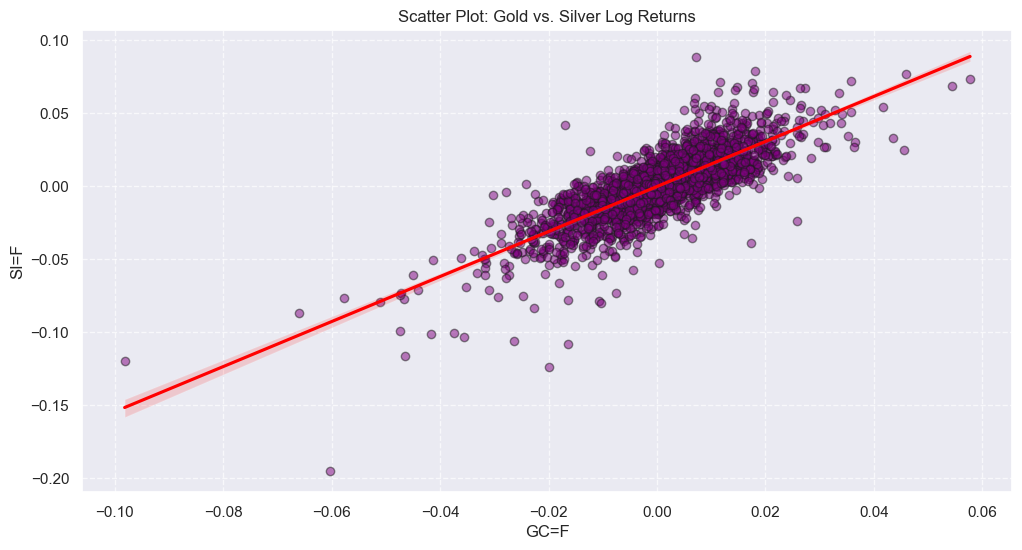

In [54]:
# Create a new figure with a specified size
plt.figure(figsize=(12, 6))  # Initialize a figure with a width of 12 inches and a height of 6 inches

# Create a scatter plot of Gold vs. Silver log returns
plt.scatter(log_returns_gl, log_returns_sl, alpha=0.5, color='purple', edgecolor='k')  
# 
# Parameters:
# - `log_returns_gl`: Logarithmic returns for Gold
# - `log_returns_sl`: Logarithmic returns for Silver
# - `alpha=0.5`: Sets the transparency of the points to 50% for better visibility
# - `color='purple'`: Sets the color of the scatter points to purple
# - `edgecolor='k'`: Adds a black edge to each scatter point for better distinction

# Set the title of the scatter plot
plt.title("Scatter Plot: Gold vs. Silver Log Returns")  # Title of the scatter plot

# Label the x-axis
plt.xlabel("Gold Log Returns")  # Label for the x-axis

# Label the y-axis
plt.ylabel("Silver Log Returns")  # Label for the y-axis

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)  # Adds dashed grid lines with 70% opacity

# Optionally, add a regression line to visualize the trend
import seaborn as sns  # Import seaborn for advanced plotting

sns.regplot(x=log_returns_gl, y=log_returns_sl, scatter=False, ax=plt.gca(), color='red')  
# 
# Parameters:
# - `x=log_returns_gl`: Data for the x-axis
# - `y=log_returns_sl`: Data for the y-axis
# - `scatter=False`: Disables the scatter points since they're already plotted
# - `ax=plt.gca()`: Uses the current axes
# - `color='red'`: Sets the color of the regression line to red

# Display the plot
plt.show()  # Render and display the scatter plot

<Axes: xlabel='Date'>

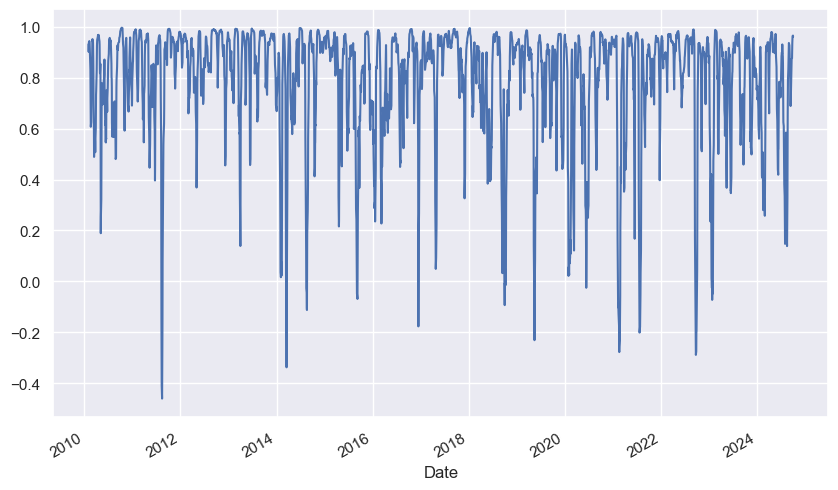

In [56]:
# Plot de rolling correlation
rolling_corr = gl.rolling(window=21).corr(sl)
rolling_corr.plot()

Text(0.5, 1.0, 'Half a year rolling correlation for Gold vs Silver')

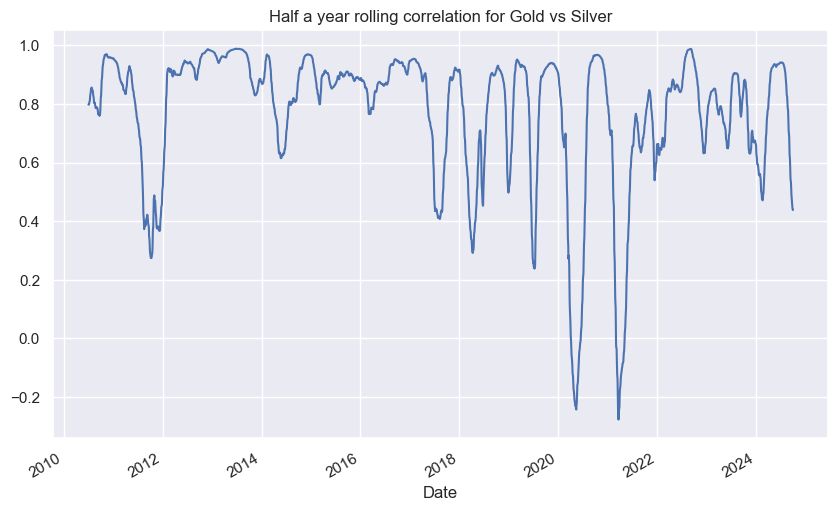

In [52]:
# Plot half a year rolling correlation
rolling_corr = gl.rolling(window=126).corr(sl)
rolling_corr.plot()
plt.title("Half a year rolling correlation for Gold vs Silver")

<Axes: xlabel='Date'>

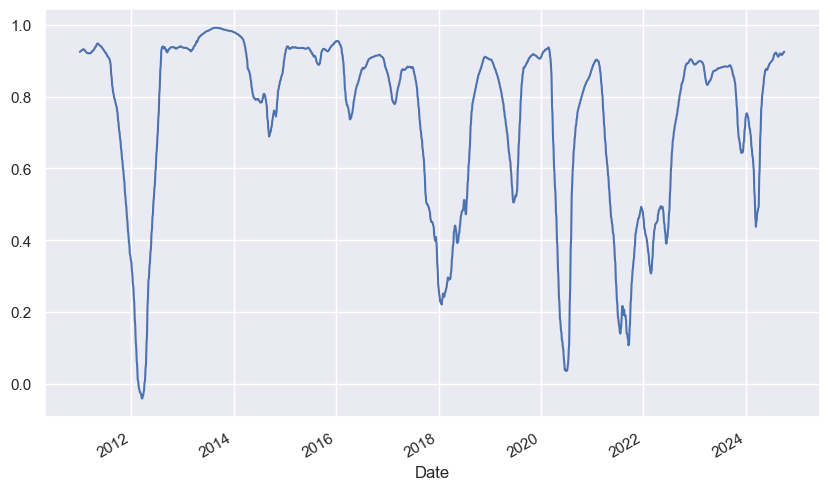

In [20]:
# Plot a year rolling correlation
rolling_corr = gl.rolling(window=252).corr(sl)
rolling_corr.plot()

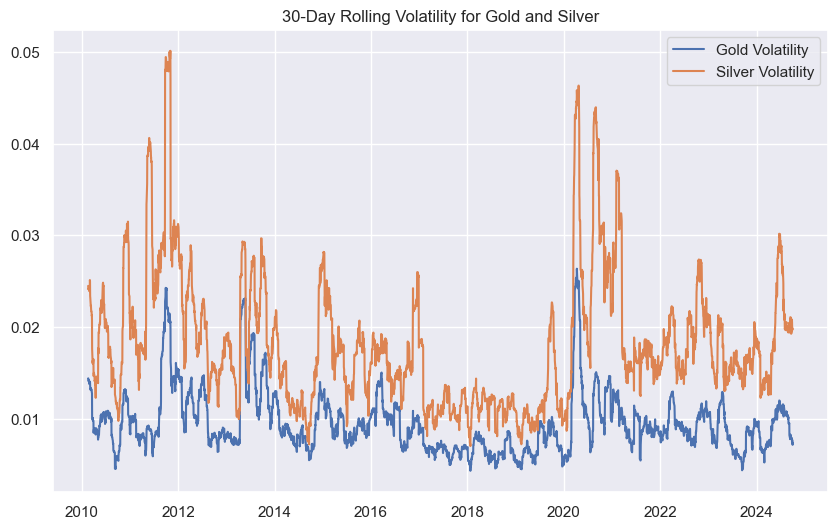

In [58]:
# Calculate the volatility (standard deviation) of the log returns for Gold using a 30-day window
volatility_gl = log_returns_gl.rolling(window=30).std()  # Apply rolling function and calculate standard deviation

# Calculate the volatility (standard deviation) of the log returns for Silver using a 30-day window
volatility_sl = log_returns_sl.rolling(window=30).std()  # Apply rolling function and calculate standard deviation

# Plot the volatility for Gold
plt.plot(volatility_gl, label="Gold Volatility")  # Plot Gold volatility and assign the corresponding label

# Plot the volatility for Silver
plt.plot(volatility_sl, label="Silver Volatility")  # Plot Silver volatility and assign the corresponding label

# Display the legend on the plot
plt.legend()  # Show the legend with the volatility labels

# Set the title of the plot
plt.title("30-Day Rolling Volatility for Gold and Silver")  # Title of the plot

# Show the plot
plt.show()  # Render and display the plot



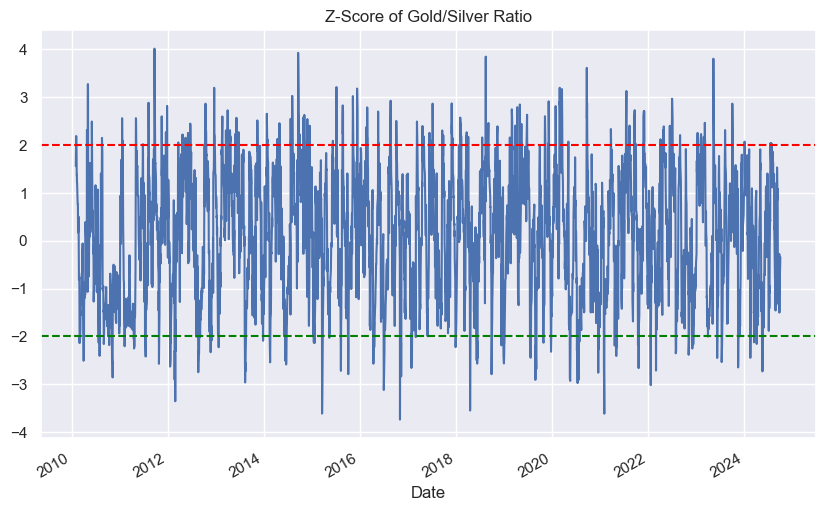

In [61]:
# Calculate the Z-score of the Gold/Silver ratio
z_score = (ratio - ratio.rolling(window=21).mean()) / ratio.rolling(window=21).std()  
# The Z-score is calculated by subtracting the rolling mean from the ratio and dividing by the rolling standard deviation over a 21-day window

# Plot the Z-score
z_score.plot(title="Z-Score of Gold/Silver Ratio")  # Plot the Z-score with a title

# Add horizontal lines at Z-score levels of +2 and -2
plt.axhline(2, color='red', linestyle='--')  # Red dashed line at Z-score = 2
plt.axhline(-2, color='green', linestyle='--')  # Green dashed line at Z-score = -2

# Show the plot
plt.show()  # Render and display the plot


## Optimización de la estrategia

In [24]:
# Calculate the ranked ratio of the Gold/Silver ratio using a 21-day rolling window
rank_ratio = ratio.rolling(window=21).rank(pct=True)  
# The rank() function assigns ranks to the values in the rolling window.
# pct=True indicates that the ranks will be expressed as percentiles (0 to 1),
# where the highest value receives a rank of 1 and the lowest a rank of 0.

# Note: The resulting rank_ratio will contain NaN values for the first 20 entries,
# as there are not enough data points to fill a full 21-day window at the beginning.

<Axes: xlabel='Date'>

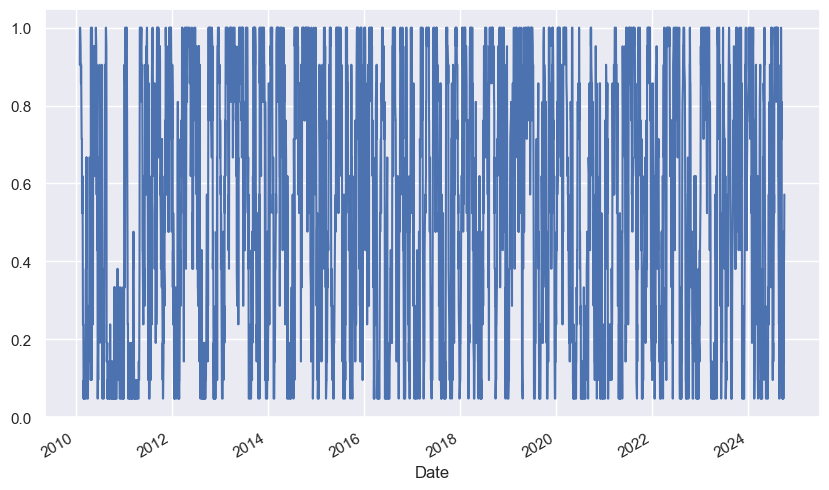

In [25]:
rank_ratio.plot()

In [26]:
roll = rank_ratio.rolling(21)  # Rolling window for rank spread
zscore = (rank_ratio - roll.mean()) / roll.std()  # Z-score calculation

In [27]:
zscore

Date
2010-01-04 05:00:00+00:00         NaN
2010-01-05 05:00:00+00:00         NaN
2010-01-06 05:00:00+00:00         NaN
2010-01-07 05:00:00+00:00         NaN
2010-01-08 05:00:00+00:00         NaN
                               ...   
2024-09-25 04:00:00+00:00   -0.624951
2024-09-26 04:00:00+00:00   -0.948562
2024-09-27 04:00:00+00:00   -0.310460
2024-09-30 04:00:00+00:00    0.126331
2024-10-01 04:00:00+00:00    0.438443
Length: 3711, dtype: float64

In [39]:
# Backtest the strategy
long_entries = zscore.vbt.crossed_above(1)
long_exits = zscore.vbt.crossed_below(-3)
clean_long_entries, clean_long_exits = long_entries.vbt.signals.clean(long_exits)

pf = vbt.Portfolio.from_signals(
    close=slv,
    entries=clean_long_entries,
    exits=clean_long_exits,
    size=1.0,
    size_type="percent",
    init_cash=25_000,
    freq="1D",
)

In [40]:
pf.stats()

Start                         2010-01-04 05:00:00+00:00
End                           2024-10-01 04:00:00+00:00
Period                               3711 days 00:00:00
Start Value                                     25000.0
End Value                                  64363.404532
Total Return [%]                             157.453618
Benchmark Return [%]                          64.886829
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              69.726179
Max Drawdown Duration                3378 days 00:00:00
Total Trades                                         17
Total Closed Trades                                  16
Total Open Trades                                     1
Open Trade PnL                              6637.972402
Win Rate [%]                                       50.0
Best Trade [%]                                68.446894
Worst Trade [%]                              -13

## Análisis de la estrategia

In [41]:
# Plot the results of the backtest
pf.plot(settings=dict(bm_returns=False)).show()

## Optimización de la estrategia 

In [46]:
from itertools import product  # Import product for creating combinations
from vectorbt.indicators.factory import IndicatorFactory  # Import IndicatorFactory from vectorbt

# Define entry and exit thresholds ranging from 0.1 to 3.5 with increments of 0.1
entry_th = np.arange(0.1, 3.6, 0.1)  # Entry thresholds
exit_th = np.arange(0.1, 3.6, 0.1)  # Exit thresholds

# Create all possible combinations of entry and exit thresholds
threshold_combinations = list(product(entry_th, exit_th))  # Generates a list of tuples with all combinations

def simulate_all_params(zscore, threshold_combinations): 
    # Define a custom Z-score indicator using the IndicatorFactory
    MyZScoreIndicator = IndicatorFactory(
        class_name="MyZScoreIndicator",
        input_names=["zscore"],  # Name of the input data
        param_names=["entry_th", "exit_th"],  # Parameter names for entry and exit thresholds
        output_names=["entry_signal", "exit_signal"]  # Output signal names
    ).from_apply_func(
        # Define the logic for the indicator
        lambda zscore, entry_th, exit_th: (
            zscore > entry_th,  # Entry signal: True if Z-score exceeds entry threshold
            zscore < -exit_th  # Exit signal: True if Z-score falls below negative exit threshold
        )
    )

    # Run the indicator for all combinations of thresholds
    ind = MyZScoreIndicator.run(zscore, *zip(*threshold_combinations))

    # Extract entry and exit signals from the indicator
    entries = ind.entry_signal
    exits = ind.exit_signal

    # Clean the entry signals based on exits to avoid holding positions after exiting
    clean_long_entries, clean_long_exits = entries.vbt.signals.clean(exits)
    
    # Create a portfolio based on the entry and exit signals
    pf = vbt.Portfolio.from_signals(
        close=slv,  # The asset price data (Silver ETF)
        entries=clean_long_entries,  # Cleaned entry signals
        exits=clean_long_exits,  # Cleaned exit signals
        size=1.0,  # Size of the position (1 means fully invested)
        size_type="percent",  # Position size type as a percentage of the portfolio
        init_cash=25_000,  # Initial cash for the portfolio
        freq="1D",  # Frequency of the trading signals (daily)
    )
    
    # Calculate various performance metrics for the portfolio
    total_trades = pf.trades.count()  # Count the total number of trades executed
    total_return = pf.total_return()  # Calculate the total return of the portfolio
    sharpe_ratio = pf.sharpe_ratio()  # Calculate the Sharpe ratio for risk-adjusted performance
    max_drawdown = pf.max_drawdown()  # Calculate the maximum drawdown to assess risk
    win_rate = pf.sortino_ratio()  # Calculate the Sortino ratio (alternative win rate measure)

    # Create a DataFrame to summarize the performance metrics
    df = pd.concat([total_trades, total_return, sharpe_ratio, max_drawdown, win_rate], axis=1)
    return df  # Return the summary DataFrame


In [47]:
a = simulate_all_params(zscore, threshold_combinations)


In [48]:
a

count  total_return  \
myzscoreindicator_entry_th myzscoreindicator_exit_th                        
0.1                        0.1                          300      0.340414   
                           0.2                          279      0.168029   
                           0.3                          262      0.102037   
                           0.4                          251      0.017732   
                           0.5                          232     -0.062606   
...                                                     ...           ...   
3.5                        3.1                            3      0.003637   
                           3.2                            3     -0.261091   
                           3.3                            3     -0.261091   
                           3.4                            3     -0.261091   
                           3.5                            3     -0.188229   

                                                      sharpe_ratio  \
myzscoreindicator_entry_th myzscoreindicator_exit_th                 
0.1                        0.1                            0.241149   
                           0.2                            0.187354   
                           0.3                            0.165276   
                           0.4                            0.134953   
                           0.5                            0.104549   
...                                                            ...   
3.5                        3.1                            0.098666   
                           3.2                           -0.008573   
                           3.3                           -0.008573   
                           3.4                           -0.008573   
                           3.5                            0.033280   

                                                      max_drawdown  \
myzscoreindicator_entry_th myzscoreindicator_exit_th                 
0.1                        0.1                           -0.640376   
                           0.2                           -0.677466   
                           0.3                           -0.689978   
                           0.4                           -0.709114   
                           0.5                           -0.716086   
...                                                            ...   
3.5                        3.1                           -0.564599   
                           3.2                           -0.737085   
                           3.3                           -0.737085   
                           3.4                           -0.737085   
                           3.5                           -0.737085   

                                                      sortino_ratio  
myzscoreindicator_entry_th myzscoreindicator_exit_th                 
0.1                        0.1                             0.334606  
                           0.2                             0.259211  
                           0.3                             0.228528  
                           0.4                             0.186290  
                           0.5                             0.144356  
...                                                             ...  
3.5                        3.1                             0.132664  
                           3.2                            -0.011521  
                           3.3                            -0.011521  
                           3.4                            -0.011521  
                           3.5                             0.044932  

[1225 rows x 5 columns]

In [49]:
# Plot the total return heatmap
a["total_return"].vbt.heatmap().show()

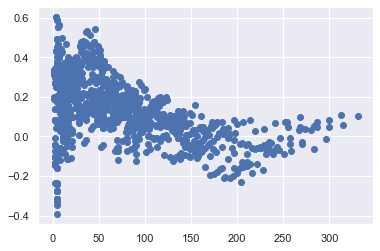

In [45]:
plt.scatter(a["count"], a["sharpe_ratio"])

## Aplicar un WFO 

In [46]:
# Define rolling split
(in_price, in_indexes), (out_price, out_indexes) = zscore.vbt.rolling_split(
    n=30,
    window_len=365 * 2,
    set_lens=(180,),
    left_to_right=False,
    trace_names=["train", "test"],
)

(in_price_stock, in_indexes_stock), (out_price_stock, out_indexes_stock) = slv.vbt.rolling_split(
    n=30,
    window_len=365 * 2,
    set_lens=(180,),
    left_to_right=False,
    trace_names=["train", "test"],
)

In [47]:
# Compare indexes from the rolling split
def compare_indexes(in_index, in_index_stock):
    # Check if the lists have the same length
    if len(in_index) != len(in_index_stock):
        print("The lists do not have the same length.")
        return False
    
    # Iterate through both indexes and compare each one
    for i, (idx1, idx2) in enumerate(zip(in_index, in_index_stock)):
        if not idx1.equals(idx2):
            print(f"The indexes do not match in DataFrame {i}")
            return False
    
    # Print if all indexes match
    print("All indexes match")
    return True

# Assuming in_index and in_index_stock are already defined variables
compare_indexes(in_indexes, in_indexes_stock)


All indexes match


True

In [48]:
entry_th = np.arange(0.1, 3.6, 0.1)  # Entry thresholds
exit_th = np.arange(0.1, 3.6, 0.1)  # Exit thresholds

# Create all possible combinations of thresholds
threshold_combinations = list(product(entry_th, exit_th))

# Simulate all possible combinations of thresholds
def simulate_all_params(in_price, threshold_combinations): 
    """simulate all possible combinations of thresholds for the crackspread strategy
    
    This function tests all possible combinations of entry and exit thresholds for the strategy.
    
    Parameters: 
    ------------
    in_price: pd.Series
        Price windows for the training period
    threshold_combinations: list
        List of all possible combinations of entry and exit thresholds
        
    Returns:
    ------------
    in_stats: pd.DataFrame
        DataFrame containing the statistics for each combination of thresholds for each window
    """
    
    MyZScoreIndicator = IndicatorFactory(
    class_name="MyZScoreIndicator",
    input_names=["in_price"],
    param_names=["entry_th", "exit_th"],
    output_names=["entry_signal", "exit_signal"]   
    ).from_apply_func(
    
    lambda in_price, entry_th, exit_th: (
    
    in_price > entry_th, 
    in_price < -exit_th
        )
    )
    
    
    # Execute the indicator for all threshold combinations
    ind = MyZScoreIndicator.run(in_price, *zip(*threshold_combinations))

    entries = ind.entry_signal
    exits = ind.exit_signal
    clean_long_entries, clean_long_exits = entries.vbt.signals.clean(exits)
    
    pf = vbt.Portfolio.from_signals(
        close=in_price_stock,
        entries=clean_long_entries,
        exits=clean_long_exits,
        size=1.0,
        size_type="percent",
        init_cash=25_000,
        freq="1D",
    )
    
    in_sharpe_ratio = pf.sharpe_ratio()
    in_total_return = pf.total_return()
    in_max_drawdown = pf.max_drawdown()
    in_sortino_ratio = pf.sortino_ratio()
    
    in_parameters = pd.concat([in_sharpe_ratio, in_total_return, in_max_drawdown, in_sortino_ratio], axis=1)
    
    return in_parameters
            

In [49]:
in_stats = simulate_all_params(in_price, threshold_combinations)

In [50]:
in_stats

sharpe_ratio  \
myzscoreindicator_entry_th myzscoreindicator_exit_th split_idx                 
0.1                        0.1                       0              0.746272   
                                                     1              0.560075   
                                                     2              0.355301   
                                                     3             -0.005848   
                                                     4              0.041423   
...                                                                      ...   
3.5                        3.5                       25                  inf   
                                                     26                  inf   
                                                     27                  inf   
                                                     28                  inf   
                                                     29                  inf   

                                                                total_return  \
myzscoreindicator_entry_th myzscoreindicator_exit_th split_idx                 
0.1                        0.1                       0              0.360581   
                                                     1              0.229791   
                                                     2              0.097311   
                                                     3             -0.095704   
                                                     4             -0.052447   
...                                                                      ...   
3.5                        3.5                       25             0.000000   
                                                     26             0.000000   
                                                     27             0.000000   
                                                     28             0.000000   
                                                     29             0.000000   

                                                                max_drawdown  \
myzscoreindicator_entry_th myzscoreindicator_exit_th split_idx                 
0.1                        0.1                       0             -0.384203   
                                                     1             -0.384203   
                                                     2             -0.384203   
                                                     3             -0.384203   
                                                     4             -0.296538   
...                                                                      ...   
3.5                        3.5                       25             0.000000   
                                                     26             0.000000   
                                                     27             0.000000   
                                                     28             0.000000   
                                                     29             0.000000   

                                                                sortino_ratio  
myzscoreindicator_entry_th myzscoreindicator_exit_th split_idx                 
0.1                        0.1                       0               0.977285  
                                                     1               0.732057  
                                                     2               0.463724  
                                                     3              -0.007546  
                                                     4               0.055415  
...                                                                       ...  
3.5                        3.5                       25                   inf  
                                                     26                   inf  
                                                     27                   inf  
                                                     28      

In [51]:
def get_best_params(performance, level_name):
    """Get the best parameters based on total_return performance.

    This function retrieves the parameter values that
    maximize the total_return for each split.

    Parameters
    ----------
    performance : pd.DataFrame
        DataFrame containing performance metrics, including total_return
    level_name : str
        The level name to extract parameter values from

    Returns
    -------
    np.ndarray
        Array of best parameter values
    """

    idx = performance.groupby("split_idx")["total_return"].idxmax()
    return performance.loc[idx].index.get_level_values(level_name).to_numpy()


In [52]:
in_best_total_return_entry = get_best_params(in_stats, "myzscoreindicator_entry_th")

In [53]:
in_best_total_return_exit = get_best_params(in_stats, "myzscoreindicator_exit_th")

In [54]:
print(f"best exit thresholds: {in_best_total_return_exit}")
print()
print(f"best entry thresholds: {in_best_total_return_entry}")

best exit thresholds: [2.3 2.3 1.  1.  0.1 2.3 0.1 0.1 0.1 0.1 0.3 3.1 2.2 2.2 2.2 2.2 0.1 0.8
 0.8 0.1 0.1 2.7 2.7 2.7 2.4 1.  0.8 0.8 0.3 0.3]

best entry thresholds: [2.3 2.1 0.2 0.2 2.4 1.3 2.5 2.5 2.5 2.5 2.4 2.7 1.5 1.9 1.9 2.  3.2 1.9
 1.6 1.9 1.9 1.8 2.  1.8 1.8 1.7 1.7 1.7 1.2 1.3]


In [55]:
in_best_th_pairs = np.array(list(zip(in_best_total_return_entry, in_best_total_return_exit)))

In [56]:
in_best_th_pairs

array([[2.3, 2.3],
       [2.1, 2.3],
       [0.2, 1. ],
       [0.2, 1. ],
       [2.4, 0.1],
       [1.3, 2.3],
       [2.5, 0.1],
       [2.5, 0.1],
       [2.5, 0.1],
       [2.5, 0.1],
       [2.4, 0.3],
       [2.7, 3.1],
       [1.5, 2.2],
       [1.9, 2.2],
       [1.9, 2.2],
       [2. , 2.2],
       [3.2, 0.1],
       [1.9, 0.8],
       [1.6, 0.8],
       [1.9, 0.1],
       [1.9, 0.1],
       [1.8, 2.7],
       [2. , 2.7],
       [1.8, 2.7],
       [1.8, 2.4],
       [1.7, 1. ],
       [1.7, 0.8],
       [1.7, 0.8],
       [1.2, 0.3],
       [1.3, 0.3]])

In [57]:
def simulate_all_params_out(out_price, threshold_combinations): 
    
    from vectorbt.indicators import IndicatorFactory

    MyZScoreIndicator = IndicatorFactory(
    class_name="MyZScoreIndicator",
    input_names=["out_price"],
    param_names=["entry_th", "exit_th"],
    output_names=["entry_signal", "exit_signal"]   
    ).from_apply_func(
    
    lambda out_price, entry_th, exit_th: (
    
    out_price > entry_th, 
    out_price < -exit_th
        )
    )
    
    
    # Execute the indicator for all threshold combinations
    ind = MyZScoreIndicator.run(out_price, *zip(*threshold_combinations))

    entries = ind.entry_signal
    exits = ind.exit_signal
    clean_long_entries, clean_long_exits = entries.vbt.signals.clean(exits)
    
    pf = vbt.Portfolio.from_signals(
        close=out_price_stock,
        entries=clean_long_entries,
        exits=clean_long_exits,
        size=1.0,
        size_type="percent",
        init_cash=25_000,
        freq="1D",
    )
    
    out_sharpe_ratio = pf.sharpe_ratio()
    out_total_return = pf.total_return()
    out_max_drawdown = pf.max_drawdown()
    out_sortino_ratio = pf.sortino_ratio()
    
    out_parameters = pd.concat([out_sharpe_ratio, out_total_return, out_max_drawdown, out_sortino_ratio], axis=1)
    
    
    return out_parameters

In [58]:
out_stats = simulate_all_params_out(out_price, threshold_combinations)

In [59]:
out_stats

sharpe_ratio  \
myzscoreindicator_entry_th myzscoreindicator_exit_th split_idx                 
0.1                        0.1                       0              0.935993   
                                                     1              0.099590   
                                                     2             -0.083984   
                                                     3             -0.207896   
                                                     4             -1.312020   
...                                                                      ...   
3.5                        3.5                       25                  inf   
                                                     26                  inf   
                                                     27                  inf   
                                                     28                  inf   
                                                     29                  inf   

                                                                total_return  \
myzscoreindicator_entry_th myzscoreindicator_exit_th split_idx                 
0.1                        0.1                       0              0.098152   
                                                     1             -0.000706   
                                                     2             -0.029889   
                                                     3             -0.044204   
                                                     4             -0.105924   
...                                                                      ...   
3.5                        3.5                       25             0.000000   
                                                     26             0.000000   
                                                     27             0.000000   
                                                     28             0.000000   
                                                     29             0.000000   

                                                                max_drawdown  \
myzscoreindicator_entry_th myzscoreindicator_exit_th split_idx                 
0.1                        0.1                       0             -0.131709   
                                                     1             -0.180418   
                                                     2             -0.162511   
                                                     3             -0.138810   
                                                     4             -0.144552   
...                                                                      ...   
3.5                        3.5                       25             0.000000   
                                                     26             0.000000   
                                                     27             0.000000   
                                                     28             0.000000   
                                                     29             0.000000   

                                                                sortino_ratio  
myzscoreindicator_entry_th myzscoreindicator_exit_th split_idx                 
0.1                        0.1                       0               1.473584  
                                                     1               0.151797  
                                                     2              -0.124978  
                                                     3              -0.305131  
                                                     4              -1.775912  
...                                                                       ...  
3.5                        3.5                       25                   inf  
                                                     26                   inf  
                                                     27                   inf  
                                                     28      

In [60]:
results = []
for i, column in enumerate(out_price.columns):
    window_price = out_price[column]  # Extract the price window for the current column (time series)
    entry_th = in_best_total_return_entry[i]  # Get the best entry threshold for the current window
    exit_th = in_best_total_return_exit[i]  # Get the best exit threshold for the current window
    window_stock_price = out_price_stock[column]  # Get the stock price for the current window
    
    # Generate entry and exit signals based on thresholds
    entries = window_price > entry_th  
    exits = window_price < -exit_th  
    clean_long_entries, clean_long_exits = entries.vbt.signals.clean(exits)  
    
    # Create a portfolio simulation from the generated signals
    pf = vbt.Portfolio.from_signals(
        close=window_stock_price,
        entries=clean_long_entries, 
        exits=clean_long_exits,
        size=1.0,  
        size_type="percent",
        init_cash=25_000, 
        freq="1D",  
    )
        
    results.append(pf.total_return())  # Append the total return of the portfolio for this window
        
# Store the results in a DataFrame with 'Total Return' as the column name
results_df = pd.DataFrame(results, columns=["Total Return"], index=out_price.columns)

    

In [61]:
results_df

,Total Return
split_idx,
0,-0.042211
1,-0.170165
2,-0.156672
3,-0.179942
4,-0.049428
5,0.018807
6,-0.005542
7,-0.019529
8,-0.014065


In [62]:
# Calculate the median of in-sample 'total_return' for each split
in_sample_median = in_stats["total_return"].groupby("split_idx").median().values

# Extract out-sample test results from results_df
out_sample_test = results_df.values

# Print the length of both in-sample and out-sample arrays to check consistency
print(len(in_sample_median), len(out_sample_test))


30 30


In [63]:
in_sample_median

array([ 0.53804252,  0.41709625,  0.02085934, -0.33584747, -0.30576554,
       -0.25361342, -0.26876482, -0.30288438, -0.2198581 , -0.22937159,
       -0.10470437, -0.06157636, -0.01857733, -0.08872747, -0.06056865,
       -0.0999772 , -0.28911206, -0.08882029, -0.08230965, -0.01685396,
       -0.04587469,  0.12745754,  0.22563197,  0.26024662,  0.16482161,
        0.23737487, -0.05486321,  0.        , -0.03975906, -0.02600017])

In [64]:
import scipy.stats as stats
t, p = stats.ttest_ind(a=out_sample_test, b=in_sample_median, alternative="greater")

In [65]:
t, p

(array([0.74865622]), array([0.2285449]))